In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("colorblind")
sns.set(font_scale = 1.1)
sns.set_style("whitegrid")

In [123]:
survey_vitals = pd.read_csv("survey_vitals_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
eval_med = pd.read_csv("evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
history_env = pd.read_csv("history_env_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()

In [78]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


In [75]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 11)
(9765, 7)
(7546, 16)


# Clustering based on geopoint data

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [125]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male


In [126]:
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]

In [127]:
scaler = StandardScaler()

In [128]:
transformed_geo = scaler.fit_transform(geo_loc)

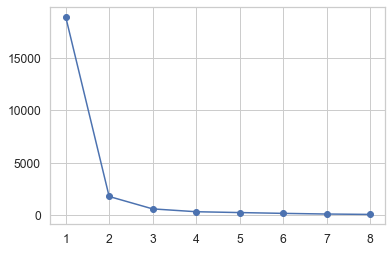

In [129]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [130]:
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [131]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex,clustersByLoc
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female,0
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female,0
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male,0
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female,0
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male,0


In [132]:
def province_clean(cluster):
    if cluster == 0:
        return "Lavega"
    elif cluster == 1:
        return "San Pedro de Macoris"
    elif cluster == 2:
        return "Santiago"
    else:
        return "San Pedro de Macoris/North"

In [133]:
survey_vitals = survey_vitals.drop(columns = ["city", "province"], axis = 1)
survey_vitals["province"] = survey_vitals["clustersByLoc"].apply(province_clean)

In [134]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,34.0,female,0,Lavega
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,52.0,female,0,Lavega
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,39.0,male,0,Lavega
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,39.0,female,0,Lavega
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,23.0,male,0,Lavega


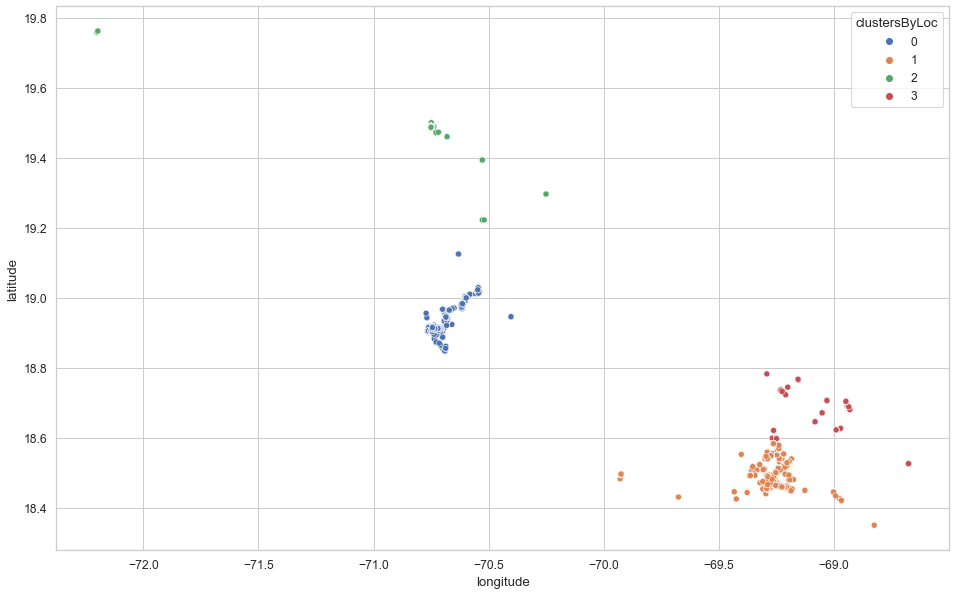

In [135]:
plt.figure(figsize = (16,10))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "clustersByLoc", palette = "deep")

# Dealing with missing values: survey_vitals

### 1. survey_vitals

In [144]:
survey_vitals.shape

(9458, 10)

In [137]:
survey_vitals.isna().sum()

objectId             0
marriageStatus    1597
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                482
sex                  0
clustersByLoc        0
province             0
dtype: int64

In [141]:
values = {"marriageStatus": , "educationLevel": , "age": survey_vitals.age.mean()}

37.0

In [ ]:
survey_vitals = survey_vitals.fillna(values = values)

### 2. eval_med

In [145]:
eval_med.shape

(8263, 7)

In [143]:
eval_med.isna().sum()

objectId                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    694
part_of_body               1491
trauma_induced              803
condition_progression       825
dtype: int64

In [ ]:
values = {"marriageStatus": , "educationLevel": , "age": survey_vitals.age.mean()}

# Mergings

### 1. History_env x survey_vitals

In [119]:
survey_environ = survey_vitals.merge(history_env, how = "inner", on = "objectId")
survey_environ.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province,...,conditionoRoofinyourhouse,medicalproblemswheredoyougo,dentalproblemswheredoyougo,biggestproblemofcommunity,timesperweektrashcollected,wheretrashleftbetweenpickups,numberofIndividualsLivingintheHouse,numberofChildrenLivinginHouseUndertheAgeof5,houseownership,bathroomAccess
0,lLkC5HGPOC,widow,Ama de casa,lessThanprimary,18.914416,-70.745642,67.0,female,0,Lavega,...,working,Other Hospital,Other Hospital,Roads,1-2,other,1,0,rented,NaN
1,gIoG2SAL99,widow,Other,lessThanprimary,18.914196,-70.746286,80.0,male,0,Lavega,...,poor,Other Hospital,Dentist,Roads,1-2,other,5,0,owned,NaN
2,GiArohoFUo,married,Other,college,18.910474,-70.747658,41.0,female,0,Lavega,...,NaN,Other,Clinic,Other,3-5,other,4,0,NaN,NaN
3,rnNw8AxEix,single,Ama de casa,primary,18.910484,-70.747650,40.0,female,0,Lavega,...,working,Other Hospital,Other,Water,1-2,other,4,0,NaN,NaN
4,YBLTPHNqsH,concubine,Other,lessThanprimary,18.915163,-70.741626,59.0,male,0,Lavega,...,working,Clinic,Other,Other,1-2,street,4,0,NaN,NaN


In [120]:
survey_environ.shape

(5423, 25)

### 2. Survey_vitals x eval_med

In [121]:
survey_med = survey_vitals.merge(eval_med, how = "inner", on = "objectId")
survey_med.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province,AssessmentandEvaluation,planOfAction,duration,part_of_body,trauma_induced,condition_progression
0,8BAdCPGEE1,concubine,Other,lessThanprimary,18.912805,-70.744914,73.0,male,0,Lavega,Yes,none,NaN,NaN,NaN,NaN
1,8BAdCPGEE1,concubine,Other,lessThanprimary,18.912805,-70.744914,73.0,male,0,Lavega,Yes,other,NaN,NaN,NaN,NaN
2,bWCqNwtKYL,concubine,Ama de casa,lessThanprimary,18.912537,-70.744927,65.0,female,0,Lavega,No,none,NaN,NaN,NaN,NaN
3,bWCqNwtKYL,concubine,Ama de casa,lessThanprimary,18.912537,-70.744927,65.0,female,0,Lavega,Yes,other,NaN,NaN,NaN,NaN
4,056xDPGU2U,concubine,Other,lessThanprimary,18.912727,-70.745074,79.0,male,0,Lavega,No,none,NaN,NaN,NaN,NaN


In [91]:
survey_med.shape

(8171, 17)

### 3. History_env x survey_med

In [94]:
env_med = history_env.merge(eval_med, how = "inner", on = "objectId")
env_med.head()

,objectId,yearsLivedinThisHouse,waterAccess,typeofWaterdoyoudrink,latrineAccess,conditionoFloorinyourhouse,conditionoRoofinyourhouse,medicalproblemswheredoyougo,dentalproblemswheredoyougo,biggestproblemofcommunity,...,numberofIndividualsLivingintheHouse,numberofChildrenLivinginHouseUndertheAgeof5,houseownership,bathroomAccess,AssessmentandEvaluation,planOfAction,duration,part_of_body,trauma_induced,condition_progression
0,FoatG2gGXl,1-2,everyday,tap,Y,dirtPoor,working,Other,Other,Other,...,8,1,owned,NaN,Yes,other,NaN,NaN,NaN,NaN
1,dzkEclDkh9,5-10,1AWeek,tap,Y,cementWorking,working,Other Hospital,Other Hospital,Water,...,3,0,owned,NaN,Yes,none,NaN,NaN,NaN,NaN
2,dzkEclDkh9,moreThan10,1AWeek,bottled,Y,cementPoor,working,Other Hospital,Other,Roads,...,5,1,owned,NaN,Yes,none,NaN,NaN,NaN,NaN
3,spnTo4zKCI,1-2,1AWeek,bottled,Y,cementWorking,poor,Other Hospital,Other,Water,...,5,2,rented,NaN,No,other,within_last_month,bones_or_joints,suddenly_but_not_due_to_trauma,NaN
4,spnTo4zKCI,1-2,1AWeek,bottled,Y,cementWorking,poor,Other Hospital,Other Hospital,Water,...,5,2,rented,NaN,No,other,within_last_month,bones_or_joints,suddenly_but_not_due_to_trauma,NaN


In [95]:
env_med.shape

(5856, 22)